<a id="top"></a>

# IMDb Analysis using SQL


## Introduction
We will use SQL to dive deep into the Internet Movie Database (IMDb) and answer different questions involving movies, actors, and movie ratings.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import xarray as xr
import sqlalchemy
from pathlib import Path

#Comment out this line after you have run it
!pip install ipython-sql


plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")
np.set_printoptions(threshold=5)
%matplotlib inline
%load_ext sql

In our variable `ds`, we have an `xarray.Dataset` object with one `xarray.DataArray` object, consisting of `snow_density` measurements across time and location. The following cell extracts the `xarray.DataArray` object consisting of snow density measurements, similar to extracting a column from a `Pandas.DataFrame`.


<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

---

# The IMDB (mini) Dataset

I will explore a miniature version of the [IMDb Dataset](https://www.imdb.com/interfaces/).

The database in going to be loaded in two ways (using both Python and SQL cell magic) so that we can flexibly explore the SQL database.

In [2]:
# run this cell and the next one
engine = sqlalchemy.create_engine("sqlite:///data/imdbmini.db")
connection = engine.connect()

In [3]:
%sql sqlite:///data/imdbmini.db

Let's take a look at the table schemas:

In [5]:
%%sql

SELECT * FROM sqlite_master WHERE type='table';

 * sqlite:///data/imdbmini.db
Done.


type,name,tbl_name,rootpage,sql
table,Title,Title,2,"CREATE TABLE ""Title"" (""tconst"" INTEGER, ""titleType"" TEXT, ""primaryTitle"" TEXT, ""originalTitle"" TEXT, ""isAdult"" TEXT, ""startYear"" TEXT, ""endYear"" TEXT, ""runtimeMinutes"" TEXT, ""genres"" TEXT)"
table,Name,Name,12,"CREATE TABLE ""Name"" (""nconst"" INTEGER, ""primaryName"" TEXT, ""birthYear"" TEXT, ""deathYear"" TEXT, ""primaryProfession"" TEXT)"
table,Role,Role,70,"CREATE TABLE ""Role"" (tconst INTEGER,ordering TEXT,nconst INTEGER,category TEXT,job TEXT,characters TEXT)"
table,Rating,Rating,41,"CREATE TABLE ""Rating"" (tconst INTEGER,averageRating TEXT,numVotes TEXT)"


From running the above cell, we see the database has 4 tables: `Name`, `Role`, `Rating`, and `Title`.

<details>
    <summary>[<b>Click to Expand</b>] See descriptions of each table's schema.</summary>
    
**`Name`** – Contains the following information for names of people.
    
- nconst (text) - alphanumeric unique identifier of the name/person
- primaryName (text)– name by which the person is most often credited
- birthYear (integer) – in YYYY format
- deathYear (integer) – in YYYY format
    
    
**`Role`** – Contains the principal cast/crew for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given tconst
- nconst (text) - alphanumeric unique identifier of the name/person
- category (text) - the category of job that person was in
- characters (text) - the name of the character played if applicable, else '\\N'
    
**`Rating`** – Contains the IMDb rating and votes information for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- averageRating (text) – weighted average of all the individual user ratings
- numVotes (text) - number of votes (i.e., ratings) the title has received
    
**`Title`** - Contains the following information for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- titleType (text) -  the type/format of the title
- primaryTitle (text) -  the more popular title / the title used by the filmmakers on promotional materials at the point of release
- isAdult (text) - 0: non-adult title; 1: adult title
- startYear (text) – represents the release year of a title.
- runtimeMinutes (integer)  – primary runtime of the title, in minutes
    
</details>

<br/><br/>
From the above descriptions, we can conclude the following:
* `Name.nconst` and `Title.tconst` are primary keys of the `Name` and `Title` tables, respectively.
* `Role.nconst` and `Role.tconst` are **foreign keys** that point to `Name.nconst` and `Title.tconst`, respectively.

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## How far back does our data go? Does it only include recent data, or do we have information about older movies and movie stars as well? 
#### I'm gonna list the **10 oldest `movie` titles** by `startYear` and then `primaryTitle` both in **ascending** order (excluding films where the `startYear` is `NULL`.  The output contains the `startYear`, `primaryTitle`, and `titleType`.



In [10]:
query1 = """
SELECT startYear, primaryTitle, titleType
FROM Title
WHERE titleType = "movie" AND startYear IS NOT NULL
ORDER BY startYear, primaryTitle ASC
LIMIT 10;
"""

res1 = pd.read_sql(query1, engine)
res1

,startYear,primaryTitle,titleType
0,1915,The Birth of a Nation,movie
1,1920,The Cabinet of Dr. Caligari,movie
2,1921,The Kid,movie
3,1922,Nosferatu,movie
4,1924,Sherlock Jr.,movie
5,1925,Battleship Potemkin,movie
6,1925,The Gold Rush,movie
7,1926,The General,movie
8,1927,Metropolis,movie
9,1927,Sunrise,movie


<br/>

<hr style="border: 1px solid #fdb515;" />

### Now, let's calculate the distribution of films by year. Next is a query that returns the **total** `movie` titles for each `startYear` in the `Title` table as `total`. I'll filter films that don't have a `startYear` listed.  Final results are ordered by `startYear` in **ascending** order.


In [12]:
query2 = """
SELECT startYear, COUNT(*) AS total
FROM Title
WHERE titleType = "movie" AND startYear IS NOT NULL
GROUP BY startYear
ORDER BY startYear ASC
"""

res2 = pd.read_sql(query2, engine)
res2

,startYear,total
0,1915,1
1,1920,1
2,1921,1
3,1922,1
4,1924,1
...,...,...
97,2017,213
98,2018,230
99,2019,194
100,2020,117


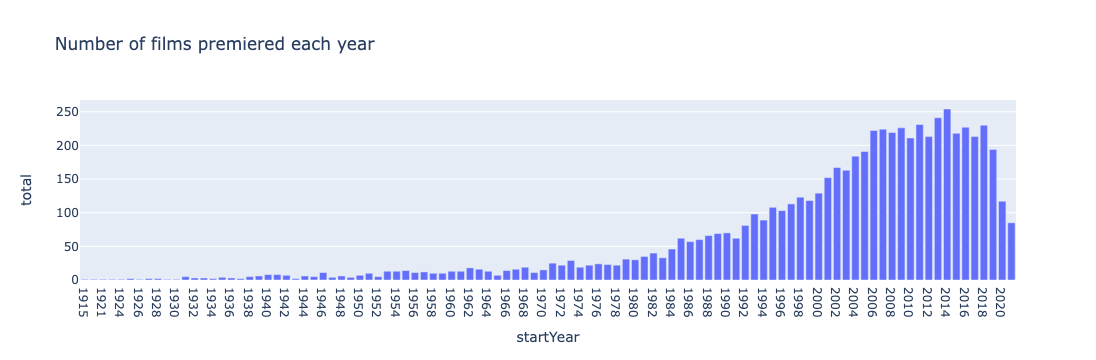

In [14]:
# plotting number of films premiered each year

px.bar(res2, x="startYear", y="total",
       title="Number of films premiered each year")

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

### Who are the **top 10 most prolific movie actors**?

In [15]:
query3 = """
SELECT primaryName AS name, COUNT(*) AS total
FROM Role R JOIN Name N JOIN Title T
WHERE R.tconst = T.tconst AND R.nconst = N.nconst AND (category = 'actor' OR category = 'actress') AND titleType = 'movie'
GROUP BY name
ORDER BY total DESC, name ASC
LIMIT 10
"""

res3 = pd.read_sql(query3, engine)
res3

,name,total
0,Robert De Niro,64
1,Samuel L. Jackson,54
2,Nicolas Cage,53
3,Bruce Willis,49
4,Tom Hanks,46
5,Johnny Depp,43
6,Mark Wahlberg,41
7,Liam Neeson,40
8,Morgan Freeman,40
9,Adam Sandler,39


<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Which movies are **"big hits"**?

I'll define "big hits" as movies that have over 100,000 votes.

In [16]:
query4 = """
WITH votes AS (
    SELECT COUNT(*) AS total,
    CASE 
        WHEN CAST(Rating.numVotes AS int) > 100000 THEN 'yes'
        ELSE 'no'
        END AS isBigHit
    FROM Rating JOIN Title
    WHERE titleType = 'movie' AND Rating.tconst = Title.tconst
    GROUP BY isBigHit
    )
SELECT isBigHit, total
FROM votes
GROUP BY isBigHit
"""

res4 = pd.read_sql(query4, engine)
res4

,isBigHit,total
0,no,4318
1,yes,2041


<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## **How does film length relate to ratings?**  
To answer this question I'm going to bin `movie` titles by length and compute the average of the average ratings within each length bin. We will group movies by 10-minute increments -- that is, one bin for movies \[0, 10) minutes long, another for \[10, 20) minutes, another for \[20, 30) minutes, and so on using this formula: 

```
ROUND(runtimeMinutes / 10.0 + 0.5) * 10 AS runtimeBin
```

In [18]:
query5 = """
SELECT ROUND(runtimeMinutes / 10.0 + 0.5) * 10 AS runtimeBin, Avg(averageRating) AS averageRating,
        Avg(numVotes) AS averageNumVotes, COUNT(*) AS total
FROM Title T JOIN Rating R ON T.tconst = R.tconst
WHERE titleType = 'movie' AND R.numVotes >= 10000
GROUP BY runtimeBin
ORDER BY runtimeBin ASC
"""

res5 = pd.read_sql(query5, engine)
res5.head()

,runtimeBin,averageRating,averageNumVotes,total
0,50.0,7.850000,42535.000000,2
1,60.0,6.400000,30668.500000,2
2,70.0,7.600000,59822.000000,13
3,80.0,6.860937,67896.187500,64
4,90.0,6.283951,76907.608466,567


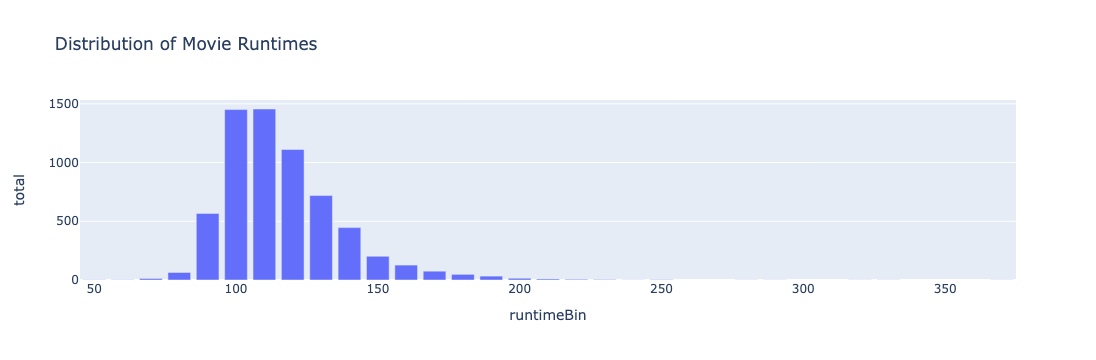

In [19]:
# plotting the distribution of Movie Runtimes
px.bar(res5, x="runtimeBin", y="total",
       title="Distribution of Movie Runtimes")

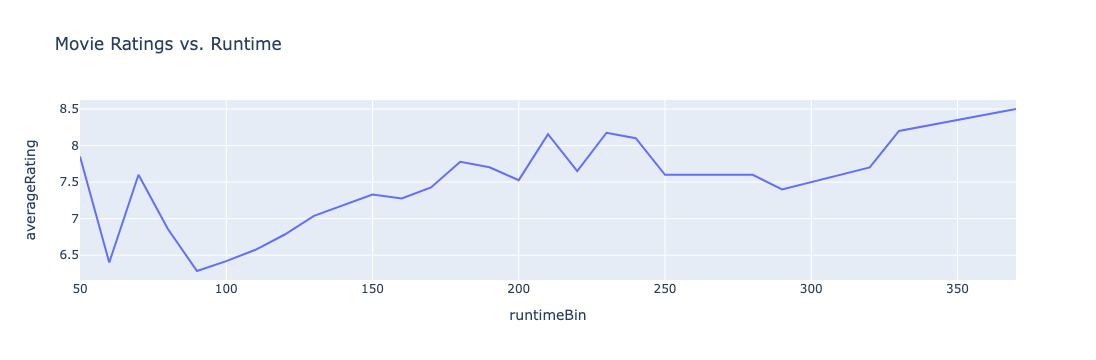

In [21]:
# plotting movie ratings vs runtime
px.line(res5, x="runtimeBin", y="averageRating",
        title="Movie Ratings vs. Runtime")

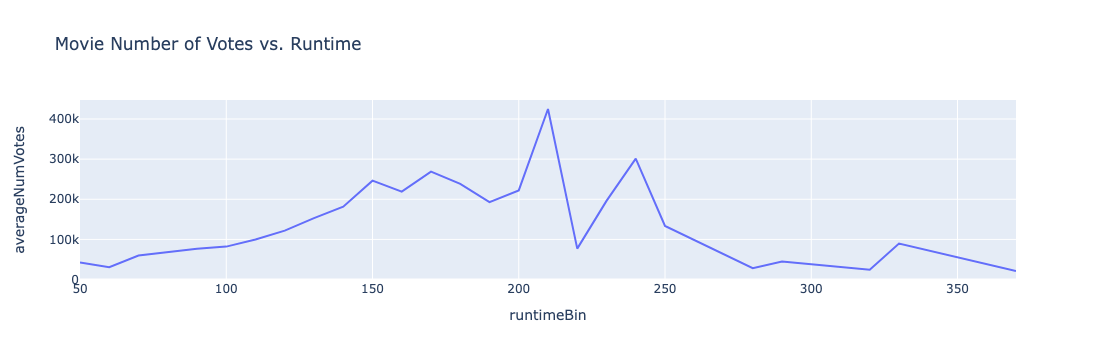

In [22]:
px.line(res5, x="runtimeBin", y="averageNumVotes",
        title="Movie Number of Votes vs. Runtime")

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Which **movie actors** have the highest average ratings across all the **movies** in which they star?

I'm only going to consider ratings where there are **at least 1000** votes and movie actors that have **at least 20** rated performances. I'm going to rescale ratings for movies in which they had a role by using this formula:

$$
\text{actorRating} = 
\frac{\sum_m \text{averageRating}[m] * \text{numVotes}[m]}{\sum_m \text{numVotes}[m]}
$$

I will present the movie actors with the **top 10** `actorRating` in descending order and break ties alphabetically using the movie actor's name.

In [23]:
query6 = """
SELECT primaryName AS name, SUM(averageRating * numVotes) / SUM(numVotes) AS actorRating
FROM Name JOIN Role ON Name.nconst = Role.nconst
    JOIN Title ON Title.tconst = Role.tconst JOIN Rating ON Rating.tconst = Role.tconst 
WHERE titleType = "movie" AND (category = "actor" or category = "actress") AND numVotes >= 1000
GROUP BY name
HAVING COUNT(name) >= 20
ORDER BY actorRating DESC
LIMIT 10;
"""

res6 = pd.read_sql(query6, engine)
res6

,name,actorRating
0,Diane Keaton,8.441302
1,Tim Robbins,8.247318
2,Al Pacino,8.138361
3,Michael Caine,8.133915
4,Leonardo DiCaprio,8.034961
5,Christian Bale,7.989825
6,Robert Duvall,7.946483
7,Jack Nicholson,7.933034
8,Kevin Spacey,7.926158
9,Clint Eastwood,7.866839
